<a href="https://colab.research.google.com/github/deburky/boosting-scorecards/blob/main/other_notebooks/visualizing_gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing Gradient Boosting 🌳

Author: https://www.github.com/deburky

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_blobs, make_hastie_10_2

def generate_data(name=None):
    if name in {'moons'}:
        X, y = make_moons(n_samples=2000, noise=0.3, random_state=62)
    elif name in {'circles'}:
        X, y = make_circles(n_samples=2000, noise=0.2, factor=0.5, random_state=62)
    elif name in {'blobs'}:
        X, y = make_blobs(n_samples=2000, centers=2, cluster_std=10, random_state=62)
    elif name in {'hastie'}:
        X, y = make_hastie_10_2(n_samples=2000, random_state=62)
        # make the target binary
        y = (y == 1).astype(int)
        # select randomly two features
        rng = np.random.RandomState(62)
        features = rng.choice(X.shape[1], 2, replace=False)
        X = X[:, features]
    else:
        X = np.random.rand(2000, 2)
        y = (X[:, 0] + X[:, 1] > 1).astype(int)
        X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    X, y = pd.DataFrame(X, columns=[r"$x_1$", r"$x_2$"]), pd.Series(y)

    return X, y

dataset_name = None

if dataset_name not in {'moons', 'circles', 'blobs', 'hastie'}:
    dataset_name = 'binary'

X, y = generate_data(dataset_name)

ix_train, ix_test = train_test_split(
    np.arange(X.shape[0]), stratify=y, test_size=0.3, random_state=62
)

## Visualization

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import log_loss
from scipy.special import expit as sigmoid

import numpy as np
from matplotlib import pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import ListedColormap
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")


class LogitBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_iter=100, learning_rate=.1, max_depth=1):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.predictors = []
        self.loss_dict = []
        self.history = []
        self.gradients = []
        self.classes_ = np.array([0, 1])
        self.is_fitted_ = False

    def fit(self, X, y):
        # Initialize weights
        F = np.zeros(X.shape[0])

        for _ in range(self.n_iter):
            # Working response and weights
            p = sigmoid(F) # probability
            z = (y - p) / (p * (1 - p)) # working response
            W = p * (1 - p) # weights

            # Fit a regressor (stump) to the working response
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, z, sample_weight=W)
            self.predictors.append(tree)

            self.history.append(F)
            self.gradients.append(z) # Store gradients

            # Update F
            F += self.learning_rate * tree.predict(X)

            # Calculate and store the loss
            loss = log_loss(y, sigmoid(F))
            self.loss_dict.append(loss)
            self.is_fitted_ = True

    def predict_proba(self, X):
        F = sum(self.learning_rate * predictor.predict(X) for predictor in self.predictors)
        proba = sigmoid(F)
        return np.vstack((1 - proba, proba)).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba > 0.5).astype(int)


class AnimatedLogitBoost:
    def __init__(self, model_class, X, y, paired_features, iterations, dataset_name, **model_params):
        self.model_class = model_class
        self.model_params = model_params
        self.X = X
        self.y = y
        self.paired_features = paired_features
        self.iterations = iterations
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.color_class_0 = "#ffd8a8"
        self.color_class_1 = "#53cef9"
        self.point_color_class_0 = "#fab005"
        self.point_color_class_1 = "#8dd9ee"
        self.marker_class_0 = "$-$"
        self.marker_class_1 = "P"
        self.cmap_background = ListedColormap(["#ffd43b", "#98e2fb"])
        self.dataset_name = dataset_name

    def fit_model(self, iteration):
        # Create a new instance of the model with the specified number of iterations
        params = self.model_params.copy()
        params['n_iter'] = iteration + 1
        self.model = self.model_class(**params)
        self.model.fit(self.X, self.y)

    def plot_decision_boundary(self, iteration):
        self.ax.clear()

        feature_1, feature_2 = np.meshgrid(
            np.linspace(self.X[self.paired_features[0]].min(), self.X[self.paired_features[0]].max(), num=200),
            np.linspace(self.X[self.paired_features[1]].min(), self.X[self.paired_features[1]].max(), num=200)
        )

        grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

        y_pred = np.reshape(
            self.model.predict_proba(grid)[:, 1],
            feature_1.shape
        )

        display = DecisionBoundaryDisplay(
            xx0=feature_1,
            xx1=feature_2,
            response=y_pred,
        )
        display.plot(ax=self.ax, cmap=self.cmap_background, alpha=0.3)

        # Retrieve gradients from each iteration
        gradients = np.abs(self.model.gradients[-1]) * 3

        for unique_label in np.unique(self.y):
            class_mask = self.y == unique_label
            class_desc = 'Approved' if unique_label == 0 else 'Not Approved'
            marker = self.marker_class_0 if unique_label == 0 else self.marker_class_1
            color = self.point_color_class_0 if unique_label == 0 else self.point_color_class_1

            # multiply the gradients by 100 to make them visible
            sizes = gradients[class_mask] * 100

            self.ax.scatter(
                self.X[self.paired_features[0]][class_mask],
                self.X[self.paired_features[1]][class_mask],
                c=[color],
                marker=marker, # type: ignore
                edgecolors='k',
                linewidth=0.3,
                s=sizes,
                label=class_desc
            )

        # turn off border around the plot
        self.ax.spines['top'].set_visible(False)
        self.ax.spines['right'].set_visible(False)
        self.ax.spines['left'].set_visible(False)
        self.ax.spines['bottom'].set_visible(False)

        # set tick line to 0
        self.ax.tick_params(axis='x', length=0)
        self.ax.tick_params(axis='y', length=0)

        # remove values from axes
        self.ax.set_xticks([])
        self.ax.set_yticks([])

        self.ax.set_xlabel(self.paired_features[0], fontsize=14, labelpad=10)
        self.ax.set_ylabel(self.paired_features[1], fontsize=14, labelpad=10)

        self.ax.set_title(f"Decision Boundary at Iteration {iteration + 1}", fontsize=14)
        # add title that it is a LogitBoost model
        plt.suptitle(f"LogitBoost ({self.dataset_name})", fontsize=18, y=0.97)

    def update(self, iteration):
        self.fit_model(iteration)
        self.plot_decision_boundary(iteration)

    def animate(self):
        return FuncAnimation(
            self.fig, self.update, frames=self.iterations, repeat=False
        )

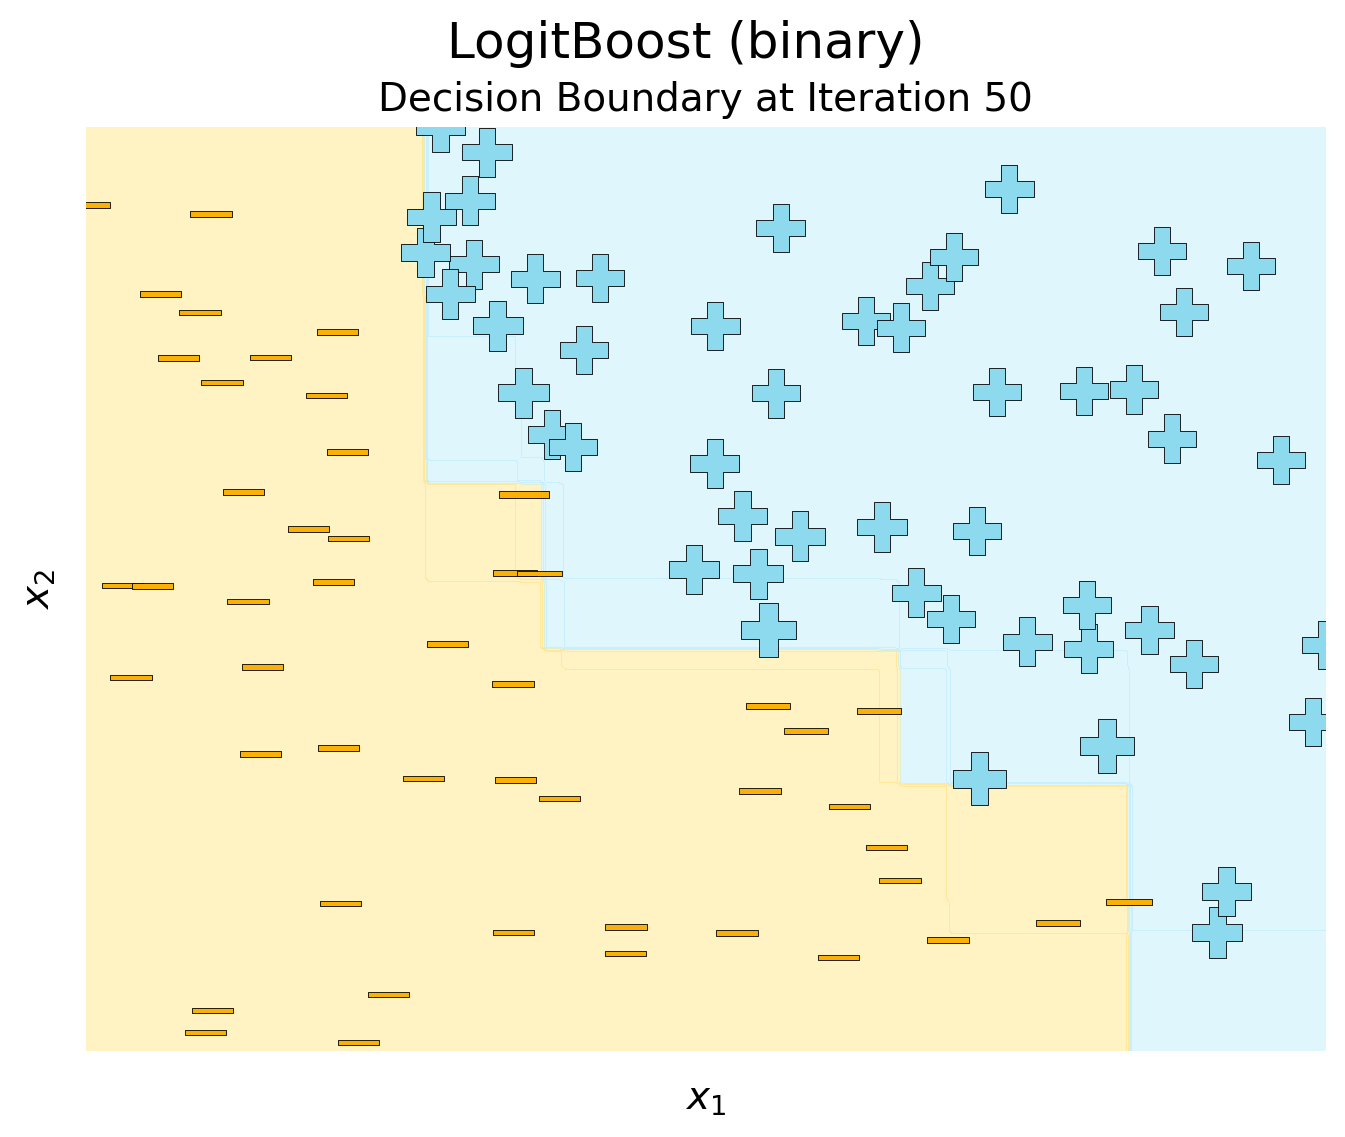

In [3]:
slice_window = slice(500, 2000)
animated_logitboost = AnimatedLogitBoost(
    LogitBoostClassifier().__class__,
    X.loc[ix_test][slice_window],
    y.loc[ix_test][slice_window],
    X.columns,
    iterations=50,
    dataset_name=dataset_name,
    **{'learning_rate': 0.5, 'max_depth': 1}
)
animation = animated_logitboost.animate()

# Save the animation as a GIF using PillowWriter
save_path = f"logitboost_decision_boundary_{dataset_name}.gif"
animation.save(save_path, writer=PillowWriter(fps=5), dpi=200)
plt.show()